In [1]:
import numpy as np 
from scipy.integrate import odeint
import os, sys, warnings
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import utility as ut
import surrogate_nn as srnn
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
warnings.filterwarnings('ignore')

In [2]:
L63_data_path = '../data/L63-trajectories'
N = 20000
train = np.load(f'{L63_data_path}/train.npy')[:, :N].astype(np.float32)
test = np.load(f'{L63_data_path}/test.npy')[:, :, :1000].astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(train[:, :-1].T), torch.Tensor(train[:, 1:].T))
# test_dataset = test = np.load(f'{L63_data_path}/test.npy')[:, :, 1000]
train_dataloader = DataLoader(train_dataset, batch_size=int(N/10))#, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

model = srnn.SurrogateModel_NN(3, 300, name='test_model', save_folder='../data/test/test_model')
x = torch.rand(3)

In [3]:
model.learn(train, epochs=1000, learning_rate=1e-3)

epoch: 0    loss: 15521151.000000     time elapsed=0.0243
epoch: 100    loss: 15521151.000000     time elapsed=2.1424
epoch: 200    loss: 15521151.000000     time elapsed=4.2068
epoch: 300    loss: 15521151.000000     time elapsed=6.1609
epoch: 400    loss: 15521151.000000     time elapsed=8.1781
epoch: 500    loss: 15521151.000000     time elapsed=10.2749
epoch: 600    loss: 15521151.000000     time elapsed=12.2799
epoch: 700    loss: 15521151.000000     time elapsed=14.2318
epoch: 800    loss: 15521151.000000     time elapsed=16.2807
epoch: 900    loss: 15521151.000000     time elapsed=18.2302
Time taken by learn is 20.3290 seconds


In [4]:
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(test[:500], error_threshold=0.05)

Time taken by compute_tau_f is 6.4911 seconds


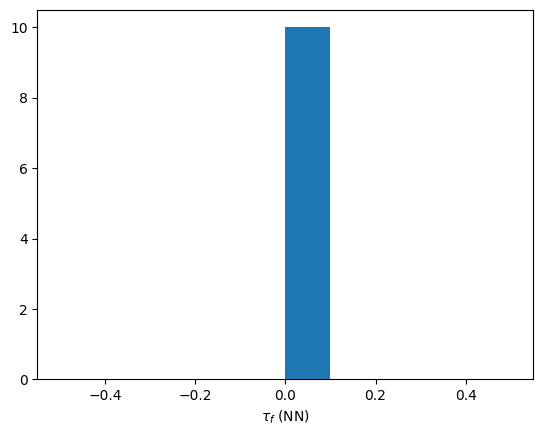

In [5]:
plt.hist(tau_f_se, density=True)
plt.xlabel(r'$\tau_f$ (NN)')
plt.savefig('../data/plots/tau_f_NN.png')
# plt.title(f'training_data_size={N}')

Time taken by compute_tau_f is 0.3758 seconds


Text(0.5, 1.0, 'training_data_size=20000')

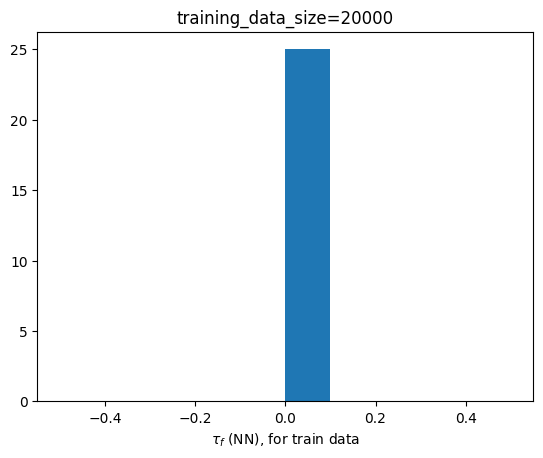

In [6]:
tau_f_rmse, tau_f_se, rmse, se = model.compute_tau_f(train.T.reshape(-1, 3, 800))

plt.hist(tau_f_se)
plt.xlabel(r'$\tau_f$ (NN), for train data')
plt.title(f'training_data_size={N}')

In [7]:
tau_f_se.mean()

0.0

In [8]:
for batch, (X, y) in enumerate(train_dataloader):
    print(X, y)

tensor([[ -8.3611, -13.3140,  18.1467],
        [ -9.3860, -14.6547,  19.6255],
        [-10.4542, -15.8231,  21.5584],
        ...,
        [  2.0305,   3.3969,  15.7262],
        [  2.3213,   3.8728,  15.0634],
        [  2.6548,   4.4476,  14.4824]]) tensor([[ -9.3860, -14.6547,  19.6255],
        [-10.4542, -15.8231,  21.5584],
        [-11.5119, -16.6562,  23.9250],
        ...,
        [  2.3213,   3.8728,  15.0634],
        [  2.6548,   4.4476,  14.4824],
        [  3.0424,   5.1353,  13.9958]])
tensor([[ 3.0424,  5.1353, 13.9958],
        [ 3.4962,  5.9518, 13.6216],
        [ 4.0290,  6.9134, 13.3851],
        ...,
        [14.0473, 11.6263, 36.7345],
        [13.3525,  8.8866, 37.5703],
        [12.2934,  6.2659, 37.5103]]) tensor([[ 3.4962,  5.9518, 13.6216],
        [ 4.0290,  6.9134, 13.3851],
        [ 4.6544,  8.0351, 13.3216],
        ...,
        [13.3525,  8.8866, 37.5703],
        [12.2934,  6.2659, 37.5103],
        [10.9839,  4.0252, 36.7231]])
tensor([[10.9839,  4

In [9]:
train.T

array([[ -8.361066 , -13.313976 ,  18.146687 ],
       [ -9.38598  , -14.654672 ,  19.625534 ],
       [-10.454209 , -15.823077 ,  21.55841  ],
       ...,
       [ -8.537725 ,  -4.837833 ,  31.28254  ],
       [ -7.811937 ,  -4.2815824,  30.380886 ],
       [ -7.1350317,  -3.9159417,  29.39694  ]], dtype=float32)

In [10]:
import torch.nn.functional as F

In [11]:
l = nn.Linear(3, 300)

In [12]:
F.tanh(l(torch.rand(3)))

tensor([ 7.2591e-01, -3.4724e-01, -2.7511e-01,  6.1129e-01, -1.1216e-01,
        -1.7826e-01, -5.2327e-01,  2.1312e-01,  7.8228e-01,  1.9264e-01,
        -3.1225e-01, -8.4823e-01, -3.6268e-01, -4.7135e-01, -9.1461e-02,
         4.2809e-01, -6.3285e-02, -8.1350e-03,  2.5848e-01, -2.7870e-01,
         2.7073e-01,  4.9469e-01, -2.8191e-01, -1.7093e-01, -5.7733e-01,
         3.5284e-01, -5.1748e-02,  6.5180e-01,  7.0430e-01, -4.5280e-01,
         3.9331e-02,  6.5948e-01,  7.2504e-01,  2.3926e-02, -4.1919e-01,
         7.1556e-01, -4.6897e-01, -7.1909e-01, -1.3418e-01, -2.4838e-01,
        -7.7726e-01,  3.4868e-01, -5.0683e-01, -3.8286e-01,  3.0096e-01,
         3.8429e-01, -2.1092e-01, -6.1968e-01,  1.9721e-01, -3.6123e-01,
        -3.0290e-01, -2.7781e-02,  6.5367e-01,  4.1645e-01,  7.4477e-01,
        -1.9997e-01, -7.8077e-03, -5.2204e-01,  3.1103e-01, -2.0707e-01,
         1.4366e-01, -6.1016e-01, -1.1673e-01, -1.8571e-01,  3.6141e-01,
         6.2979e-01,  8.4661e-02,  1.0155e-01, -7.6

In [13]:
train_dataset

In [14]:
for batch, (X, y) in enumerate(train_dataloader):
    if batch == 1:
        print(X, y)

tensor([[ 3.0424,  5.1353, 13.9958],
        [ 3.4962,  5.9518, 13.6216],
        [ 4.0290,  6.9134, 13.3851],
        ...,
        [14.0473, 11.6263, 36.7345],
        [13.3525,  8.8866, 37.5703],
        [12.2934,  6.2659, 37.5103]]) tensor([[ 3.4962,  5.9518, 13.6216],
        [ 4.0290,  6.9134, 13.3851],
        [ 4.6544,  8.0351, 13.3216],
        ...,
        [13.3525,  8.8866, 37.5703],
        [12.2934,  6.2659, 37.5103],
        [10.9839,  4.0252, 36.7231]])


In [15]:
model.net(X)

tensor([[-0.3784, -0.5052, -0.1228],
        [-0.5277, -0.6224, -0.1540],
        [-0.6175, -0.7646, -0.1120],
        ...,
        [-0.0213, -0.7353, -0.3125],
        [-0.0430, -0.7723, -0.3179],
        [-0.0654, -0.8017, -0.3057]], grad_fn=<MmBackward0>)

In [16]:
model.net(y)

tensor([[-0.5277, -0.6224, -0.1540],
        [-0.6175, -0.7646, -0.1120],
        [-0.5862, -0.8255, -0.1188],
        ...,
        [-0.0430, -0.7723, -0.3179],
        [-0.0654, -0.8017, -0.3057],
        [-0.0860, -0.8217, -0.2892]], grad_fn=<MmBackward0>)

In [17]:
nn.MSELoss()(model.net(X), y)

tensor(258.1744, grad_fn=<MseLossBackward0>)

In [18]:
torch.mean(torch.sum((model.net(X)-y)**2, axis=1)**0.5)

tensor(26.2196, grad_fn=<MeanBackward0>)

In [19]:
242.81**2

58956.6961

In [20]:
attrs(model.net.W)

NameError: name 'attrs' is not defined

In [ ]:
seq = nn.Sequential(nn.Linear(3, 300, bias=True), nn.Tanh(), nn.Linear(300, 3, bias=False))

In [ ]:
for name, param in seq.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
torch.sum(seq.state_dict()['2.weight']**2)

In [ ]:
fig, N, dt = plt.figure(figsize=(8, 8)), 500, 0.02
t = np.arange(0., N*dt, dt) / (1/0.91)
axs = [fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)]
dims = ['x', 'y', 'z']
u = np.load('{}/validation.npy'.format(L63_data_path)).astype(np.float32)
u = train
idx = [[4, 14, 18], [13, 17, 46], [13, 2, 31], ]
labels = ['good', 'medium', 'bad']
predicted = model.multistep_forecast(u[:, 0], N)
for i, ax in enumerate(axs):
    ax.plot(t, u[i, :N], label='truth')
    ax.plot(t, predicted[i, :N], label='network')
    ax.legend(loc='upper right')
    if i == len(dims)-1:
        ax.set_xlabel('t')
    ax.set_ylabel(dims[i])

In [ ]:
train.shape

In [ ]:
model = srnn.SurrogateModel_NN_multi(3, 50)
model.learn(train, epochs=10000, learning_rate=1e-3)

In [ ]:
fig, N, dt = plt.figure(figsize=(8, 8)), 500, 0.02
t = np.arange(0., N*dt, dt) / (1/0.91)
axs = [fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)]
dims = ['x', 'y', 'z']
u = np.load('{}/validation.npy'.format(L63_data_path)).astype(np.float32)
u = train
idx = [[4, 14, 18], [13, 17, 46], [13, 2, 31], ]
labels = ['good', 'medium', 'bad']
predicted = model.multistep_forecast(u[:, 0], N)
for i, ax in enumerate(axs):
    ax.plot(t, u[i, :N], label='truth')
    ax.plot(t, predicted[i, :N], label='network')
    ax.legend(loc='upper right')
    if i == len(dims)-1:
        ax.set_xlabel('t')
    ax.set_ylabel(dims[i])

In [ ]:
new_model = srnn.SurrogateModel_NN(3, 300, name='test_model', save_folder='../data/test/test_model')
new_model.net = torch.load(model.save_folder+f'/{model.name}_900')

In [ ]:
torch.load(model.save_folder+f'/{model.name}_900')(X) - new_model.net(X)